# 2 $\rightarrow$ 4 Annihilation: Outgoing Energy Spectrum

This notebook

1). Converts the energies in a .lhe file to a .csv

2). Plots a histogram of those energies from the .csv

3). Generates a probability density function from the histogram of outgoing energies



In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.integrate as integrate

print ('Complete')

Complete


In [2]:
def eventFilePath(fileName):
    return 'DarkHiggsCapture/LHEEventFiles/' + fileName

def CSVFilePath(fileName):
    return 'DarkHiggsCapture/CSVEventFiles/' + fileName

print ('Complete')

Complete


## LHE file to CSV Conversion

This cell reads in a MadGraph .lhe file and converts the outgoing energies to a .csv. 

To make the following cells work properly, in the .lhe file, YOU must:

    1). Strip off (delete) all header material 
    
    2). Remove the [return] before and after the first and last <event> tags
    
As a final check, your .lhe file should look like:

    <LesHouchesEvents version="3.0">
        <event>
            ...
        </event>
    </LesHouchesEvents>

In [4]:
name = input('Lhe File: ')
lhefile = open(eventFilePath(name))

############################
###### Usefull Things ######
# file.read()
# file.readline()
############################

dictionary = {}
counterArray = []
energyArrayRaw = []
counter = 0
for line in lhefile: # loops through all lines
#     print (line.split()) # Prints line
#     print (line.split()[0])  # Prints first element of line vector separated by whitespace
#     print (line.split()[0][0]) # Prints first element of first vector
#     if (line.split()[0] == '-15'):
#         print (line.split())
#     elif (line.split()[0] == '15'):
#         print (line.split())


    if (line.split()[0] == '25'):
        counter += 1
        value = float(line.split()[9])
        
        dictionary.update({'{0}'.format(counter):'{0}'.format(value)})
        counterArray.append(counter)
        energyArrayRaw.append(value)

#############################
# Write to Data Frame
# dataFrame = pd.DataFrame(data = dictionary.values(), columns = dictionary.keys())
# dataFrame = pd.DataFrame(data=dictionary, index = dictionary.keys())
#############################
dataFrame = pd.DataFrame(energyArrayRaw, columns = ['Energy'])
csvFileName = input('CSV File Name: ')
dataFrame.to_csv(CSVFilePath(csvFileName), index = False)

print ('Complete')

Lhe File: ii


FileNotFoundError: [Errno 2] No such file or directory: 'LHEEventFiles/ii'

## Plot Outgiong Energy Distribution

This cell reads in a csv file and creates a histogram of the data

The variable "nBins" determines the quality of the PDF interpolation from the histogram. A higher number of bins yields a more accurate interpolation.

Input CSV File: 3000GeV.csv


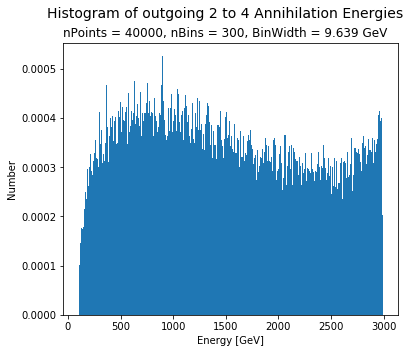

Complete


In [22]:
fileIn = input('Input CSV File: ')
dataIn = pd.read_csv(CSVFilePath(fileIn),sep = ',')
energyArrayRaw = dataIn['Energy']


nPoints = len(energyArrayRaw)
nBins = 300
binWidth = (max(energyArrayRaw)-min(energyArrayRaw))/nBins

plt.figure(figsize=(6,5))
normedenergyArray = np.array([])

#############
# This one JUST plots the histogram
# plt.hist(energyArrayRaw, bins = nBins, normed = True)

###################
# This one actually pulls out the NORMED bins which can be interpolated into a PDF
normedEnergyArray = plt.hist(energyArrayRaw, bins = nBins, normed = True)[0]
plt.suptitle('Histogram of outgoing 2 to 4 Annihilation Energies', fontsize = '14')
# plt.title('Bin Width = {0} GeV'.format(round(binWidth,3)), loc = 'right', fontsize = '12')
plt.title('nPoints = {0}, nBins = {1}, BinWidth = {2} GeV'.format(nPoints,nBins, round(binWidth,3)),loc = 'left', fontsize = '12')
plt.xlabel('Energy [GeV]')
plt.ylabel('Number')
plt.show()

print ('Complete')

## Generate Probability Density Function from Histogram

The simple approach is to extract the left or right bound of each bin and use that as your x-values for the interpolation. However, neither bound will work, because we end up interpolating over the ENTIRE array of energy values, and we will always lose one value depending if we pick the left/right bound of each bin. 

The solution is to divide up the total interpolation range into evenly spaced intervals, independent of the histogram bin widths.

Input CSV File: 3000GeV.csv
Interpolation Integration: (1.0018969521603711, 0.005874552766909513)


C:\Users\Adam Green\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


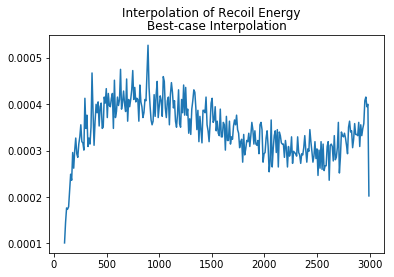

Complete


In [23]:
# Read in an .csv file
fileIn = input('Input CSV File: ')
dataIn = pd.read_csv(CSVFilePath(fileIn),sep = ',')
energyArrayRaw = dataIn['Energy']

# We do it this way because we NEED to include BOTH endpoints of the energy to interpolate over
# This is the x-list we will interpolate over
interpEnergyArray = np.linspace(min(energyArrayRaw), max(energyArrayRaw), nBins)

# Interpolation
energyPDF = interpolate.interp1d(interpEnergyArray,normedEnergyArray, kind = 'linear')

# Interpolation Test
# Since this is a Probability Density Function, it should integrate to 1
testValue = integrate.quad(energyPDF, min(energyArrayRaw), max(energyArrayRaw))
print ('Interpolation Integration: {0}'. format(testValue))

# Plot of the Interpolation
# Increasing the last argument of pltRange beyond nBins yields no improvement in the plot,
#     you are adding data where there isn't any
pltRange = np.linspace(min(energyArrayRaw),max(energyArrayRaw), nBins)

plt.plot(pltRange, energyPDF(pltRange))
plt.suptitle('Interpolation of Recoil Energy')
plt.title('Best-case Interpolation')
plt.show()

print ('Complete')

## Sanity Checks

In this cell, we check the average Energy of the PDF by computing it two ways:

1). Integrating the PDF

\begin{equation}
    \langle E \rangle = \int_{Energy} PDF(E) \ E \ dE
\end{equation}

2). Using the arithmetic average of energies from the .lhe file

\begin{equation}
    \langle E \rangle =\frac{\sum_{i}^N E_i}{N}
\end{equation}

In [24]:
# Read in an energy .csv
fileIn = input('Input CSV File: ')
dataIn = pd.read_csv(CSVFilePath(fileIn),sep = ',')
energyArrayRaw = dataIn['Energy']

def avgIntegrand(E):
    return energyPDF(E) * E

lowE  = min(energyArrayRaw)
highE = max(energyArrayRaw)
avg1 = integrate.quad(avgIntegrand, lowE, highE)


def arithAvg(data):
    runSum = 0
    for i in range(0,len(data)):
        runSum += data[i]
        
    return runSum / len(data)

avg2 = arithAvg(energyArrayRaw)

print ('Method 1: {0}'.format(avg1))
print ('Method 2: {0}'.format(avg2))

Input CSV File: 3000GeV.csv


C:\Users\Adam Green\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Method 1: (1501.9158128721751, 7.664886295626502)
Method 2: 1500.0000000001073
